# Digital For Industrial Summative - Part 1
 
## Creating A Digital Thread


A Digital Thread is the one unifying theme or characteristic that connects every aspect of an asset or unit, right from its inception and design, to manufacture, deployment, operations, maintenance to eventual retirement.

In analysis, a digital thread is the logical with which we bind and merge the various data sources into one whole, so that it lends itself to quantitative approaches easily.

<img src = 'images/Digital_Thread.JPG' width=500>


A digital thread is a technique to 'stitch' the data that comes in disjoint tables, such that they can be put together logically. That is a task for this exercise.

Data sets provided:

We have been give 5 data sets, all of which related to one month's worth of readings taken at a live volcano site. The volcano was instrumented with multiple sensors in 10 different geographical points (nodes). Our goal is to combine and merge all of this into one digital thread, making it amenable for analysis.

Tasks:

    1.0 Read all the needed input files
    2.0 Plotting Sensor Time Series
    3.0 Descriptive Analysis One data frame at a time 
    4.0 Creating a Digital Thread from the data sets
    5.0 Time Series based analysis
    6.0 Correlations Analysis
    7.0 Data Manipulations to Merge multiple data sets
    8.0 Building A Battery Remaining-Life prediction model

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import os

In [33]:
%matplotlib inline

### 1.0 Read all the needed input files

Create multiple data frames, one to hold each data table.

Convert all Data frame time stamps into date-time format, so that time-based indexing is possible

In [34]:
data_dir = 'data/Volcano'

In [35]:
_files = os.listdir(data_dir)
print(_files)

['datapoints.csv', 'datatypes.csv', 'nodes.csv', 'sensors.csv', 'volcanos.csv']


In [36]:
datatypes=pd.read_csv(_files[1])
datapoints=pd.read_csv(_files[0],parse_dates=['timestamp'])
nodes=pd.read_csv(_files[2],parse_dates=['created_at','updated_at'])
sensors=pd.read_csv(_files[3],parse_dates=['created_at','updated_at'])
volcanos=pd.read_csv(_files[4],parse_dates=['created_at','updated_at'])

### 2. Plotting Sensor Time Series

Create separate plots for each sensor in the dataset. Store each one in a separate file.

**What (if anything) can we tell about the various sensors from the plots?**


In [37]:
datapoints_copy=datapoints.copy()
datapoints_copy.set_index("timestamp", inplace=True)

In [38]:
xticks=pd.date_range(datapoints_copy.index.min(),datapoints_copy.index.max(),freq='2D')

In [39]:
for sensor in datapoints_copy.sensor_id.unique():
    s=datapoints_copy[datapoints_copy.sensor_id==sensor]
    t=sensors[sensors.id==sensor].data_type_id.values
    n=sensors[sensors.id==sensor].node_id.values
    sensor_type=datatypes[datatypes.id==t[0]].type_id.values
    sensor_unit=datatypes[datatypes.id==t[0]].si_unit.values
    sensor_node=nodes[nodes.id==n[0]].name.values

    # Plotting of figures
    ax =s["value"].plot(color='blue', figsize=(20, 8), linewidth=2, fontsize=12)
    ax.set_title(sensor_node[0]+"-"+sensor,fontsize=14)
    ax.set_ylabel(sensor_type[0]+"("+sensor_unit[0]+")",fontsize=14)
    ax.set_xlabel("DATE",fontsize=14)
    ax.set_xlim(datapoints_copy.index.min(),datapoints_copy.index.max())
    ax.set_xticks(xticks)
    plt.xticks(rotation='vertical')
    #Saving figures
    plt.savefig("images/"+sensor_node[0]+"-"+sensor+"("+sensor_type[0]+")"+'.png')
    plt.clf()
    plt.close()

### 3.0 Descriptive Analysis One data frame at a time **

3.1: How many sensors of each type are there?

In [40]:
i=0
dict={'Sensor Type':[],'Number':[]}
for sensor_type in sensors.data_type_id.value_counts().index:
    dict['Sensor Type'].append(datatypes[datatypes.id==sensor_type].type.values[0])
    dict['Number'].append(sensors.data_type_id.value_counts()[i])
    i+=1
pd.DataFrame.from_dict(dict)

,Sensor Type,Number
0,carbon dioxide concentration,10
1,battery,10
2,temperature,10
3,humidity,10
4,pressure,10
5,hydrogen sulfide concentration,10
6,RSAM,1


**ANS:** The 61 sensors installed used for the measurement fall into 6 different types. All sensor type except RSAM have 10 installed. `RSAM` has one installed.

----

### 4.0 Creating a Digital Thread from the data sets**

**Goal: Merge everything into one wide data table ** 

You have two data frames: `sensors` and `types` Merge each sensors with its type. (Hint: Use `pd.merge()`)

Question: What does this achieve? Why should we do this?

Now take the raw `data` data frame and merge it with all the `sensors` and their types.

In [41]:
sensor_type=pd.merge(sensors, datatypes, left_on='data_type_id', right_on='id').drop("id_y",axis=1)

In [42]:
full = pd.merge(datapoints, sensor_type, left_on='sensor_id', right_on='id_x').drop('id_x',axis=1)
full.set_index('timestamp',inplace=True)
full.head()

,id,value,sensor_id,description,data_frequency,status,created_at,updated_at,data_type_id,node_id,type,si_unit,type_id
timestamp,,,,,,,,,,,,,
2016-08-03 04:39:25,764c5e60-8679-11e6-a353-2f6c041e2491,98.0,7635c920-8679-11e6-a353-2f6c041e2491,\N,1800000,OFFLINE,2016-08-03 04:39:25,2016-09-29 20:13:52.793,35dcdad2-8679-11e6-bda3-ef77801087ee,762b8ff0-8679-11e6-a353-2f6c041e2491,battery,percentage,BAT
2016-08-03 04:47:41,765251d0-8679-11e6-a353-2f6c041e2491,98.0,7635c920-8679-11e6-a353-2f6c041e2491,\N,1800000,OFFLINE,2016-08-03 04:39:25,2016-09-29 20:13:52.793,35dcdad2-8679-11e6-bda3-ef77801087ee,762b8ff0-8679-11e6-a353-2f6c041e2491,battery,percentage,BAT
2016-08-03 05:08:52,7655fb50-8679-11e6-a353-2f6c041e2491,98.0,7635c920-8679-11e6-a353-2f6c041e2491,\N,1800000,OFFLINE,2016-08-03 04:39:25,2016-09-29 20:13:52.793,35dcdad2-8679-11e6-bda3-ef77801087ee,762b8ff0-8679-11e6-a353-2f6c041e2491,battery,percentage,BAT
2016-08-03 05:14:08,7659cbe0-8679-11e6-a353-2f6c041e2491,98.0,7635c920-8679-11e6-a353-2f6c041e2491,\N,1800000,OFFLINE,2016-08-03 04:39:25,2016-09-29 20:13:52.793,35dcdad2-8679-11e6-bda3-ef77801087ee,762b8ff0-8679-11e6-a353-2f6c041e2491,battery,percentage,BAT
2016-08-03 05:28:55,765dea90-8679-11e6-a353-2f6c041e2491,96.0,7635c920-8679-11e6-a353-2f6c041e2491,\N,1800000,OFFLINE,2016-08-03 04:39:25,2016-09-29 20:13:52.793,35dcdad2-8679-11e6-bda3-ef77801087ee,762b8ff0-8679-11e6-a353-2f6c041e2491,battery,percentage,BAT


-----

### 5.0 Time Series based analysis

Now, we are going to take this stitiched data frame and use it for our analysis. Specifically, we are going to perform Time-based analysis on this data.

    Step 1: Take the `full` data frame and make the Time Stamp datetime format
    Step 2: Resample the dataset to the daily level. (One observation per date)
    Step 3: For the resampled data, calculate the daily mean, min and max values for each sensor.

Resample to get daily averages.
Then subset to select the rows you need.

In [43]:
full_copy=full[['sensor_id','value']].copy()
full_copy1=full[['sensor_id','value']].copy()

In [44]:
daily_index=pd.date_range(str(datapoints_copy.index.min())[:10],str(datapoints_copy.index.max())[:10],freq='D')
daily_sample=pd.DataFrame(index=daily_index)

In [45]:
daily_sample_min=daily_sample.copy()
daily_sample_max=daily_sample.copy()
daily_sample_mean=daily_sample.copy()

In [46]:
for sensor in full_copy.sensor_id.unique():
    daily_sample_min[sensor].drop('id_x',axis=1)[sensor]=full_copy[full_copy.sensor_id==sensor]['value'].resample('D').min()
    daily_sample_max[sensor]=full_copy[full_copy.sensor_id==sensor]['value'].resample('D').max()
    daily_sample_mean[sensor]=full_copy[full_copy.sensor_id==sensor]['value'].resample('D').mean()

In [48]:
#pd.wide_to_long(daily_sample_min,["7"],i="timestamp",j="min")

In [49]:
list(full.type_id.unique())

['BAT', 'GP_H2S', 'TCA', 'PA', 'GP_CO2', 'HUMA', 'RSAM']

### 6.0 Correlations Analysis

The next task is to perform a correlation analysis. 

1.  Goal: We want to find all the sensors that are strongly correlated to each other.
2. One of the reasons for doing this is that if two (or more) sensors are very highly correlated, we only need to keep one out of each correlated set. (This reduces the problem size and also takes care of colinearlity-related unstability in certain calculations.)

The Correlation heatmap that we are looking for should be along the following lines:


<img src = "images/Corr_plot.JPG" width=450>

First, look for correlations visually. 

**Subtask: Plot all the sensors values (of one type) over time.**

Sub task: Identify all the temperature sensors in the data set. Hint: These are the ones that have the string 'TCA' in their name id's

In [63]:
temp_sensors=sensors.id[sensors.data_type_id==datatypes.id[datatypes.type_id =='TCA'][0]]

temp_sensors

3     763ca6f0-8679-11e6-a353-2f6c041e2491
12    c15a6371-8679-11e6-a353-2f6c041e2491
18    7644bd40-8679-11e6-a353-2f6c041e2491
22    c15f9391-8679-11e6-a353-2f6c041e2491
29    763bbc90-8679-11e6-a353-2f6c041e2491
32    d3cf6cd0-8679-11e6-a353-2f6c041e2491
36    d3d909c1-8679-11e6-a353-2f6c041e2491
44    d3d53930-8679-11e6-a353-2f6c041e2491
52    c5e881a1-867a-11e6-a353-2f6c041e2491
60    e6678e91-8679-11e6-a353-2f6c041e2491
Name: id, dtype: object

** Using Pandas to plot all the temperature sensors on one single plot. **

- Use pandas to loop over each temperature sensor, and plot them one at a time.
- Hint: Use the following trick to do this is to plot one line at a time, over and over in a loop

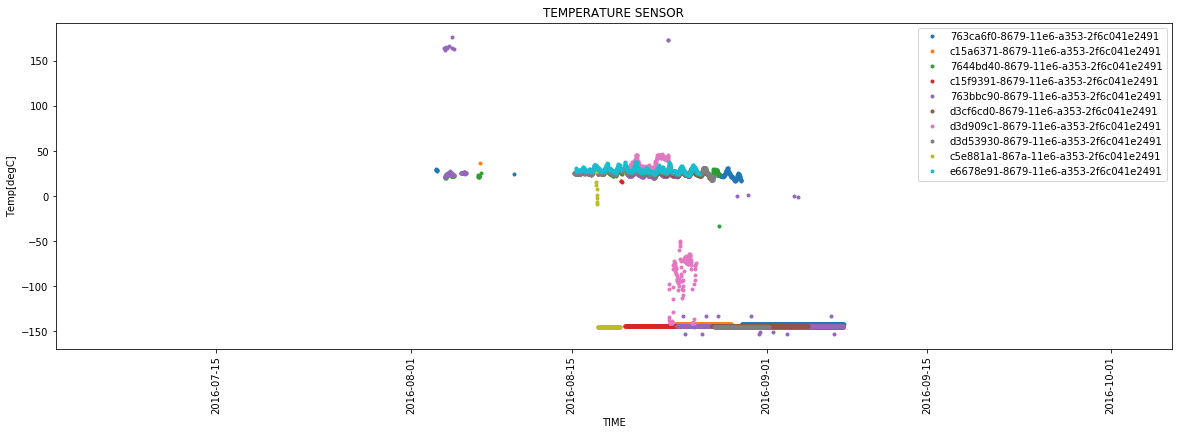

In [69]:
plt.figure(figsize=(20,6))
for s in temp_sensors:
    sub_df = full[full['sensor_id']==s]
    plt.plot(sub_df.index, sub_df['value'],'.',label=s)
    plt.xlim(datapoints_copy.index.min(),datapoints_copy.index.max())
    plt.title("TEMPERATURE SENSOR")
    plt.ylabel("Temp[degC]")
    plt.xlabel("TIME")
    #plt.xticks(xticks)
    plt.legend(ncol=1)
    plt.xticks(rotation='vertical')
    

This plot is fine, but all the lines are too close together. We cannot see how each sensor is behaving. For that, we can try drawing "Subplots." In these plots, each sensor gets its own plot (called a 'panel').

**Creating Subplots - Each sensor gets its own panel**

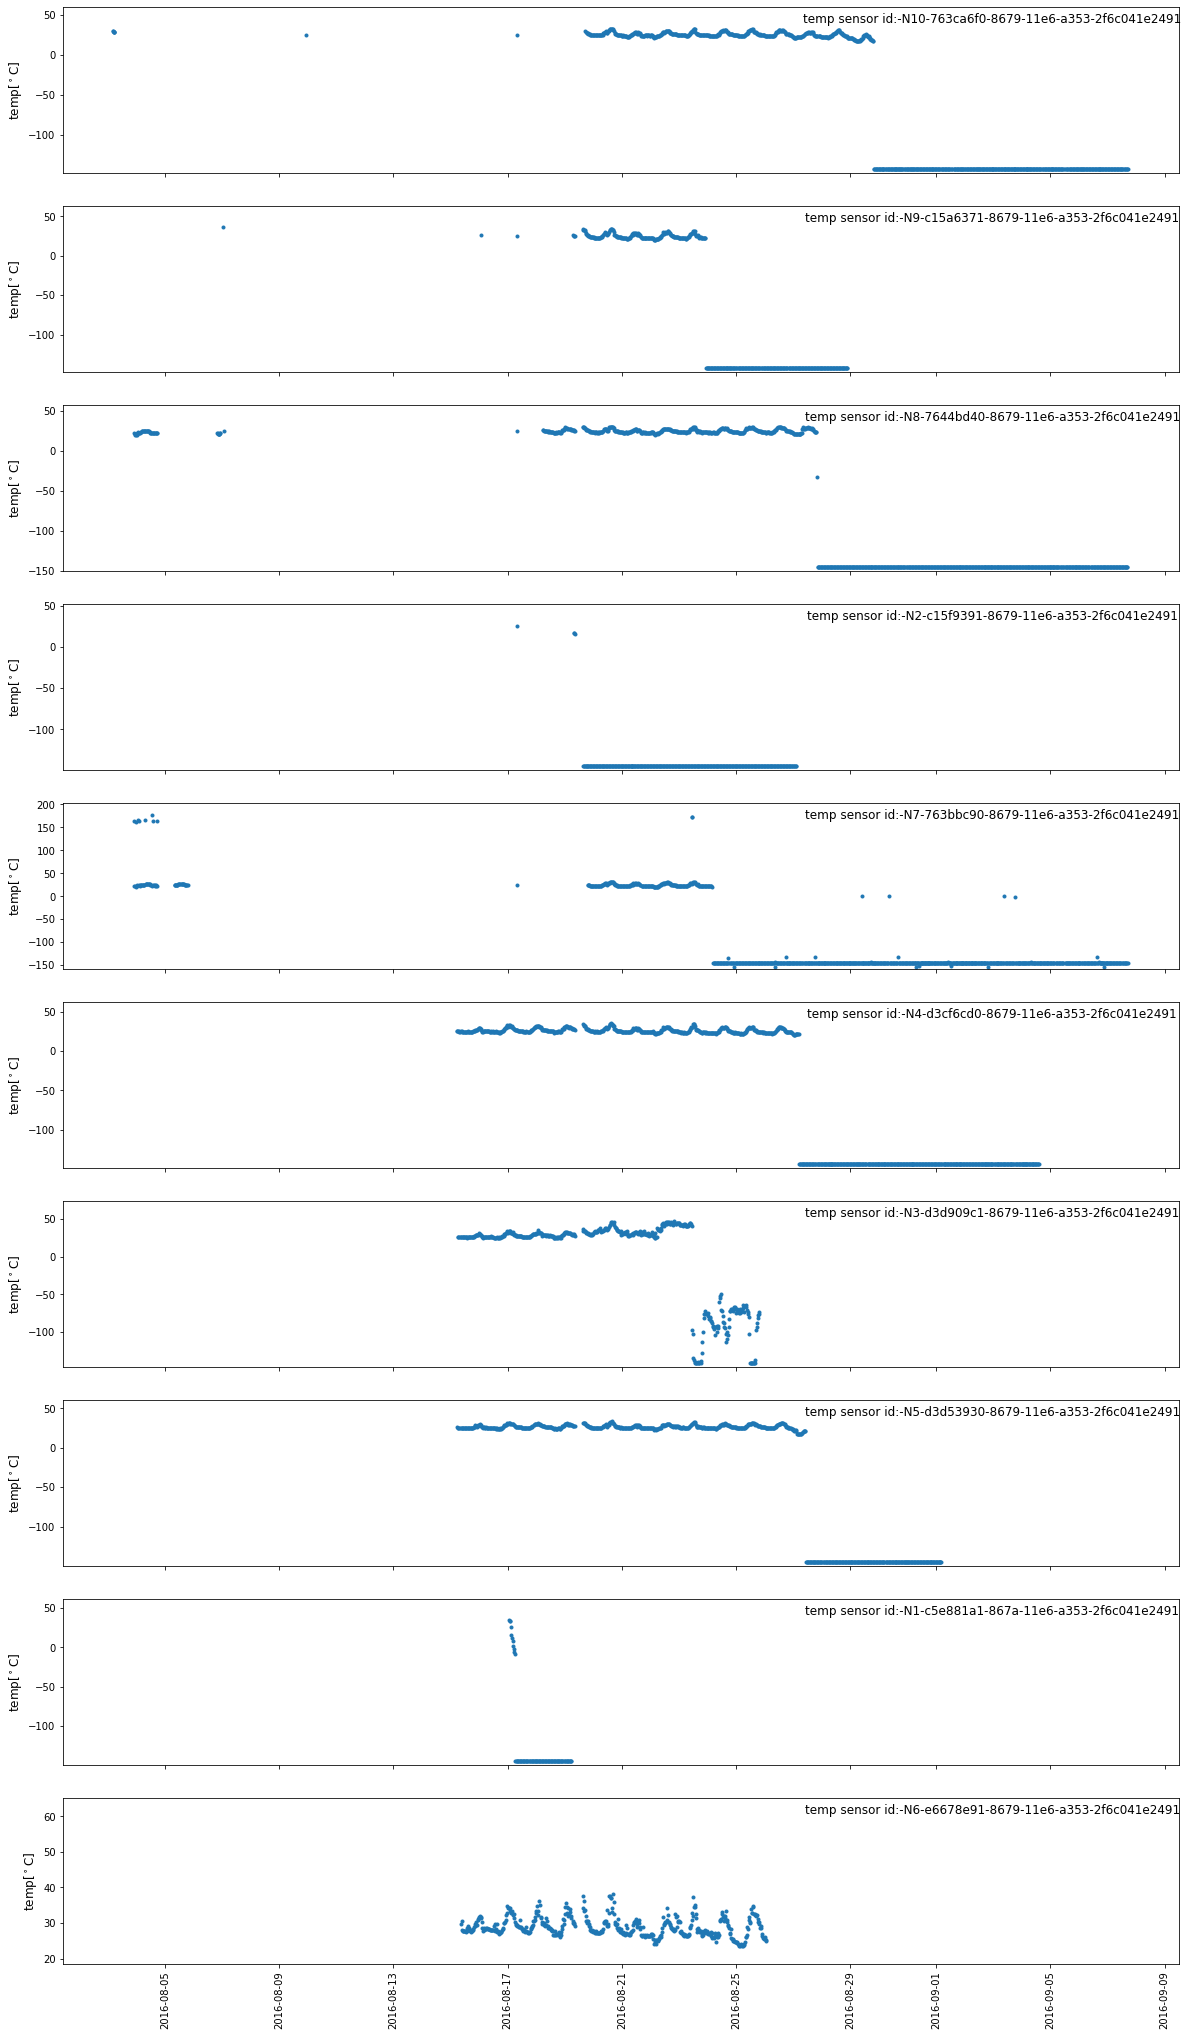

<Figure size 1440x1440 with 0 Axes>

In [88]:
fig, axarr = plt.subplots(10, sharex=True,squeeze=True)
fig.set_size_inches(20,36) 
#plt.xticks(xticks)
plt.xticks(rotation='vertical')


plt.figure(figsize=(20,20))    
for i,s in enumerate(temp_sensors):
    sub_df= full[full['sensor_id']==s]
    n=nodes[nodes.id==sub_df.node_id.values[0]].name.values[0]
    axarr[i].plot(sub_df.index, sub_df['value'],".",label=s)
    axarr[i].set_title('temp sensor id:'+"-"+n+"-"+s,position=(0.833,0.87))
    axarr[i].set_ylabel('temp[$^\circ$C]',fontsize=12)
    axarr[i].format_xdata=mdates.DateFormatter('%Y-%m-%d')
    #axarr[i].set_xlim(datapoints_copy.index.min(),datapoints_copy.index.max())
    #axarr[i].set_xticks(pd.date_range(sub_df.index.min(),sub_df.index.max(),freq='2D'))
    axarr[i].set_ylim(sub_df['value'].min()-5,sub_df['value'].max()+27)
    
    

**Task: Creating a reshaped Data Frame of just Temperature sensors**

For this, we are going to have each column be 1 sensor... from 1 to 10. The rows will be timestamps, as before.

Hint: pd.pivot() is perfect for this task.

In [53]:
# df.pivot(index='patient', columns='obs', values='score')

In [93]:
temp_df = full[full['sensor_id'].isin(temp_sensors)]
temp_df = temp_df.reset_index()
temp_df.pivot(columns='sensor_id', values='value').head()

sensor_id,763bbc90-8679-11e6-a353-2f6c041e2491,763ca6f0-8679-11e6-a353-2f6c041e2491,7644bd40-8679-11e6-a353-2f6c041e2491,c15a6371-8679-11e6-a353-2f6c041e2491,c15f9391-8679-11e6-a353-2f6c041e2491,c5e881a1-867a-11e6-a353-2f6c041e2491,d3cf6cd0-8679-11e6-a353-2f6c041e2491,d3d53930-8679-11e6-a353-2f6c041e2491,d3d909c1-8679-11e6-a353-2f6c041e2491,e6678e91-8679-11e6-a353-2f6c041e2491
0,NaN,29.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,29.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,28.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,28.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,28.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since this is a real sensor data set, there are some time stamps and sensor_id's that are repeating. (Unfortunately, this happens often in real data sets.)

**Task: Find all rows with the same [Timestamp, Sensor_id] and delete them **

**Here's a clever way to find out all the duplicated rows.**

Some Timestamp and sensor_id are repeating. That causes Indexing problems.

In [55]:
#pd.concat(g for _, g in df.groupby("ID") if len(g) > 1)
pd.concat(g for _, g in temp_df.groupby(['timestamp', 'sensor_id']) if len(g) > 1);

**Task: Drop all the rows where timestamp and sensor_id are duplicated**

In [95]:
tdf = temp_df.drop_duplicates(subset = ['timestamp', 'sensor_id'], keep='first')
# Hint: Look at https://segment.com/blog/5-advanced-testing-techniques-in-go/

In [127]:
temp_df_cor = tdf.pivot(index='timestamp', columns='sensor_id', values='value')
print('rows:',temp_df_cor.shape[0],' columns:',temp_df_cor.shape[1])
temp_df_cor.head(3)

rows: 27477  columns: 10


sensor_id,763bbc90-8679-11e6-a353-2f6c041e2491,763ca6f0-8679-11e6-a353-2f6c041e2491,7644bd40-8679-11e6-a353-2f6c041e2491,c15a6371-8679-11e6-a353-2f6c041e2491,c15f9391-8679-11e6-a353-2f6c041e2491,c5e881a1-867a-11e6-a353-2f6c041e2491,d3cf6cd0-8679-11e6-a353-2f6c041e2491,d3d53930-8679-11e6-a353-2f6c041e2491,d3d909c1-8679-11e6-a353-2f6c041e2491,e6678e91-8679-11e6-a353-2f6c041e2491
timestamp,,,,,,,,,,
2016-08-03 04:39:25,NaN,29.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-03 04:47:41,NaN,29.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-03 05:08:52,NaN,28.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
daily_temp_cor_df = temp_df_cor.resample('D').mean()
daily_temp_cor_df.head(3)

sensor_id,763bbc90-8679-11e6-a353-2f6c041e2491,763ca6f0-8679-11e6-a353-2f6c041e2491,7644bd40-8679-11e6-a353-2f6c041e2491,c15a6371-8679-11e6-a353-2f6c041e2491,c15f9391-8679-11e6-a353-2f6c041e2491,c5e881a1-867a-11e6-a353-2f6c041e2491,d3cf6cd0-8679-11e6-a353-2f6c041e2491,d3d53930-8679-11e6-a353-2f6c041e2491,d3d909c1-8679-11e6-a353-2f6c041e2491,e6678e91-8679-11e6-a353-2f6c041e2491
timestamp,,,,,,,,,,
2016-08-03,78.082000,28.865,21.067500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-04,48.245556,NaN,23.583611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-05,25.652609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, we are finally ready to calculate the correlations across sensor values. Hint: `Use corr()`

In [100]:
corr_df = daily_temp_cor_df.corr()
corr_df

sensor_id,763bbc90-8679-11e6-a353-2f6c041e2491,763ca6f0-8679-11e6-a353-2f6c041e2491,7644bd40-8679-11e6-a353-2f6c041e2491,c15a6371-8679-11e6-a353-2f6c041e2491,c15f9391-8679-11e6-a353-2f6c041e2491,c5e881a1-867a-11e6-a353-2f6c041e2491,d3cf6cd0-8679-11e6-a353-2f6c041e2491,d3d53930-8679-11e6-a353-2f6c041e2491,d3d909c1-8679-11e6-a353-2f6c041e2491,e6678e91-8679-11e6-a353-2f6c041e2491
sensor_id,,,,,,,,,,
763bbc90-8679-11e6-a353-2f6c041e2491,1.000000,0.604068,0.726736,0.994261,0.308354,1.000000,0.732838,0.677272,0.872380,0.652321
763ca6f0-8679-11e6-a353-2f6c041e2491,0.604068,1.000000,0.862264,0.147197,-0.360202,-1.000000,0.773070,0.731762,-0.289171,0.066722
7644bd40-8679-11e6-a353-2f6c041e2491,0.726736,0.862264,1.000000,0.415333,0.119104,-0.295498,0.956649,0.976520,-0.129649,0.323607
c15a6371-8679-11e6-a353-2f6c041e2491,0.994261,0.147197,0.415333,1.000000,0.317385,-1.000000,0.534663,0.507379,0.906632,0.643251
c15f9391-8679-11e6-a353-2f6c041e2491,0.308354,-0.360202,0.119104,0.317385,1.000000,1.000000,0.138210,0.131605,0.289810,0.384183
c5e881a1-867a-11e6-a353-2f6c041e2491,1.000000,-1.000000,-0.295498,-1.000000,1.000000,1.000000,-0.303960,-0.190118,-0.382485,-0.207631
d3cf6cd0-8679-11e6-a353-2f6c041e2491,0.732838,0.773070,0.956649,0.534663,0.138210,-0.303960,1.000000,0.993264,0.502033,0.857822
d3d53930-8679-11e6-a353-2f6c041e2491,0.677272,0.731762,0.976520,0.507379,0.131605,-0.190118,0.993264,1.000000,-0.135213,0.516142
d3d909c1-8679-11e6-a353-2f6c041e2491,0.872380,-0.289171,-0.129649,0.906632,0.289810,-0.382485,0.502033,-0.135213,1.000000,0.468487


In [101]:
# Create a mask to display only the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal).
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

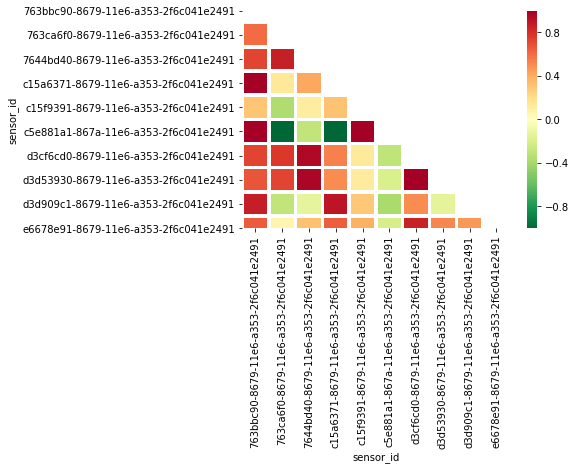

In [61]:
# Create the heatmap using seaborn library. 
# List if colormaps (parameter 'cmap') is available here: http://matplotlib.org/examples/color/colormaps_reference.html
sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
 
# Show the plot we reorient the labels for each column and row to make them easier to read.
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

In [129]:
full_copy=full.copy()
full_copy.reset_index(inplace=True);
full_copy.head(3)

,timestamp,id,value,sensor_id,description,data_frequency,status,created_at,updated_at,data_type_id,node_id,type,si_unit,type_id
0,2016-08-03 04:39:25,764c5e60-8679-11e6-a353-2f6c041e2491,98.0,7635c920-8679-11e6-a353-2f6c041e2491,\N,1800000,OFFLINE,2016-08-03 04:39:25,2016-09-29 20:13:52.793,35dcdad2-8679-11e6-bda3-ef77801087ee,762b8ff0-8679-11e6-a353-2f6c041e2491,battery,percentage,BAT
1,2016-08-03 04:47:41,765251d0-8679-11e6-a353-2f6c041e2491,98.0,7635c920-8679-11e6-a353-2f6c041e2491,\N,1800000,OFFLINE,2016-08-03 04:39:25,2016-09-29 20:13:52.793,35dcdad2-8679-11e6-bda3-ef77801087ee,762b8ff0-8679-11e6-a353-2f6c041e2491,battery,percentage,BAT
2,2016-08-03 05:08:52,7655fb50-8679-11e6-a353-2f6c041e2491,98.0,7635c920-8679-11e6-a353-2f6c041e2491,\N,1800000,OFFLINE,2016-08-03 04:39:25,2016-09-29 20:13:52.793,35dcdad2-8679-11e6-bda3-ef77801087ee,762b8ff0-8679-11e6-a353-2f6c041e2491,battery,percentage,BAT


In [130]:
full2 = full_copy.drop_duplicates(subset = ['timestamp', 'sensor_id'], keep='first')
full2.head(3)

,timestamp,id,value,sensor_id,description,data_frequency,status,created_at,updated_at,data_type_id,node_id,type,si_unit,type_id
0,2016-08-03 04:39:25,764c5e60-8679-11e6-a353-2f6c041e2491,98.0,7635c920-8679-11e6-a353-2f6c041e2491,\N,1800000,OFFLINE,2016-08-03 04:39:25,2016-09-29 20:13:52.793,35dcdad2-8679-11e6-bda3-ef77801087ee,762b8ff0-8679-11e6-a353-2f6c041e2491,battery,percentage,BAT
1,2016-08-03 04:47:41,765251d0-8679-11e6-a353-2f6c041e2491,98.0,7635c920-8679-11e6-a353-2f6c041e2491,\N,1800000,OFFLINE,2016-08-03 04:39:25,2016-09-29 20:13:52.793,35dcdad2-8679-11e6-bda3-ef77801087ee,762b8ff0-8679-11e6-a353-2f6c041e2491,battery,percentage,BAT
2,2016-08-03 05:08:52,7655fb50-8679-11e6-a353-2f6c041e2491,98.0,7635c920-8679-11e6-a353-2f6c041e2491,\N,1800000,OFFLINE,2016-08-03 04:39:25,2016-09-29 20:13:52.793,35dcdad2-8679-11e6-bda3-ef77801087ee,762b8ff0-8679-11e6-a353-2f6c041e2491,battery,percentage,BAT


In [131]:
full_wide = full2.pivot(index='timestamp', columns='sensor_id', values='value')
full_wide.head(3)

sensor_id,1248ff60-e707-11e6-89c8-314aa4f67f8c,7635c920-8679-11e6-a353-2f6c041e2491,7635f030-8679-11e6-a353-2f6c041e2491,7636da90-8679-11e6-a353-2f6c041e2491,763701a0-8679-11e6-a353-2f6c041e2491,763701a1-8679-11e6-a353-2f6c041e2491,763b9580-8679-11e6-a353-2f6c041e2491,763bbc90-8679-11e6-a353-2f6c041e2491,763ca6f0-8679-11e6-a353-2f6c041e2491,763d6a40-8679-11e6-a353-2f6c041e2491,...,d3d909c0-8679-11e6-a353-2f6c041e2491,d3d909c1-8679-11e6-a353-2f6c041e2491,d3db2ca0-8679-11e6-a353-2f6c041e2491,d3db53b0-8679-11e6-a353-2f6c041e2491,e66592c0-8679-11e6-a353-2f6c041e2491,e6678e90-8679-11e6-a353-2f6c041e2491,e6678e91-8679-11e6-a353-2f6c041e2491,e66851e0-8679-11e6-a353-2f6c041e2491,e66851e1-8679-11e6-a353-2f6c041e2491,e6691530-8679-11e6-a353-2f6c041e2491
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-07-01 00:00:31,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 00:10:02,213.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 00:20:00,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
daily_all_sensors = full_wide.resample('D').mean()

In [136]:
print('Daily sensors:- rows:',daily_all_sensors.shape[0],' columns:',daily_all_sensors.shape[1])
daily_all_sensors.head(3)

Daily sensors:- rows: 98  columns: 61


sensor_id,1248ff60-e707-11e6-89c8-314aa4f67f8c,7635c920-8679-11e6-a353-2f6c041e2491,7635f030-8679-11e6-a353-2f6c041e2491,7636da90-8679-11e6-a353-2f6c041e2491,763701a0-8679-11e6-a353-2f6c041e2491,763701a1-8679-11e6-a353-2f6c041e2491,763b9580-8679-11e6-a353-2f6c041e2491,763bbc90-8679-11e6-a353-2f6c041e2491,763ca6f0-8679-11e6-a353-2f6c041e2491,763d6a40-8679-11e6-a353-2f6c041e2491,...,d3d909c0-8679-11e6-a353-2f6c041e2491,d3d909c1-8679-11e6-a353-2f6c041e2491,d3db2ca0-8679-11e6-a353-2f6c041e2491,d3db53b0-8679-11e6-a353-2f6c041e2491,e66592c0-8679-11e6-a353-2f6c041e2491,e6678e90-8679-11e6-a353-2f6c041e2491,e6678e91-8679-11e6-a353-2f6c041e2491,e66851e0-8679-11e6-a353-2f6c041e2491,e66851e1-8679-11e6-a353-2f6c041e2491,e6691530-8679-11e6-a353-2f6c041e2491
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-07-01,306.902098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-02,267.804196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-03,286.972028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Trying to building a Linear Model**

In order to do that, we first need to create a data frame with the columns representing only those sensors for ONE NODE.

Try to see if pd.pivot() can help with grouping Nodes together

In [ ]:
nodes.name # so we have 10 "nodes" with 6 sensors each. [T, Pr, HUMA, PPM , PPM2, BATT]
nodes

In [ ]:
fullnode = pd.merge(full.reset_index(), nodes,left_on='node_id', right_on='id')

fullnode.head()

In [ ]:
fullnode.columns, fullnode.index

In [ ]:
fullnode.head()

In [ ]:
fullnode.set_index('timestamp', inplace=True)

In [ ]:
fullnode.resample('D').mean()

In [ ]:
# fullnode.pivot_table(index=['timestamp', 'name'], columns='type', values='value')
fn_wide = fullnode.pivot_table(index=['timestamp','name'], columns=['type'], values='value')


In [ ]:
#Now, let's make the Node ('name') into its own column. We do this by reset_index() for that level (=1)
fn_wide.reset_index(level=1, inplace=True)

In [ ]:
fn_wide.head()

Before we can perform Linear Regression, we have one last step remaining. We'd like to "resample" all the data, aggregating it down to 'Daily' Levels.

In [ ]:
lmfn = fn_wide.resample('D').mean()

In [ ]:
lmfn.shape

### End of Stitching. 

**The Digital Thread for this dataset has been created**

This "digital Thread" has been used to 'stitch' the data frame with all the values we wish to analyze.

---
Now we finally have the data frame in the shape we wanted to enable Linear Regression.

### 8.0 Sample Modeling

**8.1 Building A Battery Remaining-Life prediction model **
Build a machine learning model (LR, tree-based or any other) to try and predict the Battery life (remaining) as a function of any of the other sensor characteristic.

* Which variable (sensor) is a good predictor of battery life?
* Is your linear regression a "good fit?"
* What it the RMSE of your predicted values?

In [ ]:
lmfn1=lmfn[['battery', 'temperature']].dropna(axis=0)

In [ ]:
lmfn1.shape

In [ ]:
#==============================================================================
# Supervised learning linear regression
#==============================================================================

from sklearn import linear_model

# Split the data into training/testing sets
train = lmfn1[:21]
test = lmfn1[21:]

In [ ]:
target, predictors = 'battery', 'temperature'

x_train=train[predictors].to_frame() #converts the pandas Series to numpy.ndarray
y_train=train[target].to_frame()
x_test=test[predictors].to_frame() #converts the pandas Series to numpy.ndarray
y_test=test[target].to_frame()

In [ ]:
x_train

In [ ]:
y_test.values

In [ ]:
# 2.- Create linear regression object
regr = linear_model.LinearRegression()

# 3.- Train the model using the training sets
regr.fit(x_train.values,y_train.values)

# The coefficients
print("Coefficients: ",  float(regr.coef_))
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(x_train) - y_train) ** 2))

In [ ]:
print('Accuracy: {}'.format(regr.score(x_test, y_test)))

In [ ]:
regr.predict(x_test)

In [ ]:
y_test